# PSUPR / PRMLS CA2

### Team
Kenneth Goh Chia Wei : A0198544N  
Tan Heng Han : A0198502B  
Raymond Ng Boon Cheong : A0198543R

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pprint
import lxml
import re
import os
import glob
import gensim
import time
import warnings
from collections import Counter
import itertools

from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.multiclass import unique_labels

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raymo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Create a function for cleaning up tweets

In [53]:
def tweet_cleaner(text):
    # Init WordPunctTokenizer
    tok = WordPunctTokenizer()
    # create reg expression
    pat1 = r'@[A-Za-z0-9]+'
    pat2 = r'https?://[A-Za-z0-9./]+'
    combined_pat = r'|'.join((pat1, pat2))
    # Use beautiful soup to decode html to text
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    # strip text using regular expression
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    # strip to letters only
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    # remove retweets handle
    removed_rt = re.sub('RT ','',letters_only)
    # set to lower case for all characters
    lower_case = removed_rt.lower()
    # Use tokenize to remove whitespace created by letters_only above
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

### Load Data from csv
Read all tweets from their respective csv and append everything into a single dataframe. Use directory name for their respective label.

In [54]:
dataset_directories = {
    'happy': '..\dataset\happy',
    'sad': '..\dataset\sad',
    'angry': '..\dataset\\angry',
}

def getTweetsFromCSV(directory):
    files = glob.glob(directory + '\*.csv')
    dfs = [pd.read_csv(f) for f in files]
    dfs_combined = pd.concat(dfs, ignore_index=True)
    return dfs_combined

In [55]:
%%time
dfs = []
# Populate a dataset from all tweets in csv files, files have been seperated to their respectively named folders
for directory in dataset_directories:
    all_dfs = getTweetsFromCSV(dataset_directories[directory])
    all_dfs['label'] = directory
    dfs.append(all_dfs)

df_col = dfs[0].columns
final = pd.concat(dfs, ignore_index=True)
df = pd.DataFrame(final, columns=df_col)

Wall time: 381 ms


In [56]:
df.head()

,text,weekday,month,day,hour,has_hashtag,has_url,fav_count,is_reply,retweet_count,followers,following,user,screen_name,label
0,RT @AntonioAntigna8: '\n\n brillia...,Fri,Sep,20,7,0,0,0,0,2,0,0,Antonio Antignani,AntonioAntigna8,happy
1,RT @AntonioAntigna8: '\n\n you\nhave\n ...,Fri,Sep,20,7,0,0,0,0,2,0,0,Antonio Antignani,AntonioAntigna8,happy
2,09.20.18 ~ the most magical night of my life 💜...,Fri,Sep,20,6,1,0,0,0,0,309,391,nisha🇨🇦💜🌸,nisha6240,happy
3,The #EUPHORIC Agbada \n#geteuphoric #euphorias...,Fri,Sep,20,6,1,1,0,0,0,733,814,EUPHORIA,Euphorianigeria,happy
4,RT @_kosmek_: The Euphoric Sound Is What Contr...,Fri,Sep,20,6,1,0,0,0,3,93,106,HaTi,Ha71_ES09,happy


In [57]:
df.shape

(40048, 15)

In [58]:
# Keep only the tweets and its label
text = df['text']
label = df['label']
text.head()

0    RT @AntonioAntigna8: '\n\n             brillia...
1    RT @AntonioAntigna8: '\n\n      you\nhave\n   ...
2    09.20.18 ~ the most magical night of my life 💜...
3    The #EUPHORIC Agbada \n#geteuphoric #euphorias...
4    RT @_kosmek_: The Euphoric Sound Is What Contr...
Name: text, dtype: object

In [59]:
label.head()

0    happy
1    happy
2    happy
3    happy
4    happy
Name: label, dtype: object

### Clean up all tweets
Call the _tweet_cleaner_ method to process all tweets in the dataframe

In [60]:
%%time
cleaned_tweets = []
for tweet in text:
    cleaned_tweets.append(tweet_cleaner(tweet))
print((cleaned_tweets[:5]))
print(f'Tweets total: {len(cleaned_tweets)}')

['brilliant euphoric simply adrift', 'you have a thought rebel euphoric your', 'the most magical night of my life forevergrateful euphoric happyoneyearcandies', 'the euphoric agbada geteuphoric euphoriastylishman euphoriatrads', 'kosmek the euphoric sound is what controls me lahj jumpstyle hardjump euphoric hardstyle faded']
Tweets total: 40048
Wall time: 8.56 s


### Rejoin all tweets and remove duplicated tweets

In [61]:
finalDF = pd.DataFrame({'text': cleaned_tweets, 'label': label})
finalDF.drop_duplicates(subset='text', inplace=True, keep='first')

In [62]:
finalDF.shape

(20771, 2)

In [63]:
finalDF.head()

,text,label
0,brilliant euphoric simply adrift,happy
1,you have a thought rebel euphoric your,happy
2,the most magical night of my life forevergrate...,happy
3,the euphoric agbada geteuphoric euphoriastylis...,happy
4,kosmek the euphoric sound is what controls me ...,happy


### Display label distributions

Text(0.5, 1.0, 'Tweets Label Distributions')

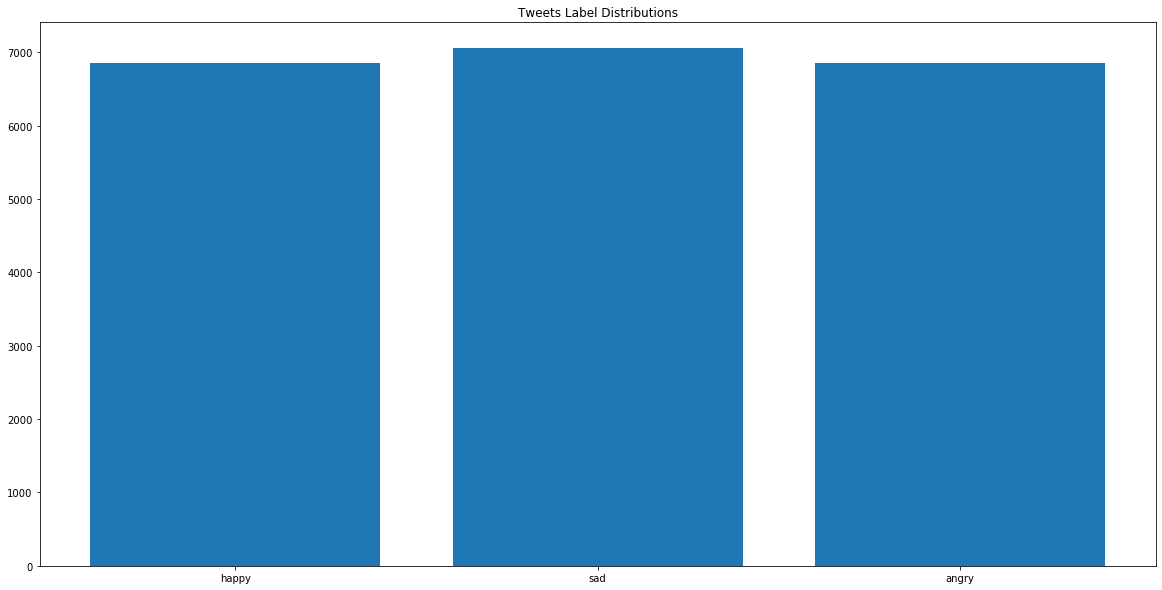

In [65]:
label_count = Counter(finalDF.label)
plt.figure(figsize=(20, 10))
plt.bar(label_count.keys(), label_count.values())
plt.title('Tweets Label Distributions')

### Preprocess Dataset

In [66]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [67]:
def preprocess(text, stem=False):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [68]:
%%time
finalDF.text = finalDF.text.apply(lambda x: preprocess(x))

Wall time: 466 ms


In [69]:
finalDF.iloc[0][0]

'brilliant euphoric simply adrift'

### Train, Test set split

In [70]:
X_train, X_test = train_test_split(finalDF, test_size=0.2, random_state=42)

In [71]:
X_train.head()

,text,label
26389,carlson cut hurt,sad
3236,sad realdonaldtrump faketweets wall built vict...,happy
33468,happy birthday one third hot tempered triad th...,angry
33958,robbie henshaw doubt ireland world cup opener ...,angry
28974,heated argument takes cut lives short place ad...,angry


In [72]:
%%time
# Break each tweets into individual words
documents = [_text.split() for _text in X_train.text]

Wall time: 17.2 ms


In [73]:
documents[0]

['carlson', 'cut', 'hurt']

### Create word vocab

In [74]:
w2vec = gensim.models.word2vec.Word2Vec(size=300, window=7, min_count=10, workers=8)
w2vec.build_vocab(documents)
words = w2vec.wv.vocab.keys()
vocab_size=len(words)
print("Vocab size:", vocab_size)

Vocab size: 2523


In [75]:
%%time
w2vec.train(documents, total_examples=len(documents), epochs=32)

Wall time: 2.45 s


(3249631, 5083872)

In [76]:
# Check for similar words
w2vec.most_similar("happy")

[('wishing', 0.6536476612091064),
 ('bday', 0.6428234577178955),
 ('tuesday', 0.6358062028884888),
 ('everyday', 0.6010749936103821),
 ('birthday', 0.5930919051170349),
 ('smiling', 0.5563946962356567),
 ('energy', 0.5491549968719482),
 ('minister', 0.5352070331573486),
 ('wishes', 0.5339441299438477),
 ('cheerful', 0.5173643827438354)]

### Tokenize Text

In [77]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.text)
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 28471
Wall time: 278 ms


In [78]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train.text), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test.text), maxlen=300)

Wall time: 361 ms


In [79]:
labels = finalDF.label.unique().tolist()
labels

['happy', 'sad', 'angry']

### Change label to categorical values

In [90]:
encoder = LabelEncoder()
encoder.fit(X_train.label.tolist())

y_train = encoder.transform(X_train.label.tolist())
y_test = encoder.transform(X_test.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)
# 'Onehot' encoder labels
y_train_labels = to_categorical(y_train, num_classes=3)
y_test_labels = to_categorical(y_test, num_classes=3)

y_train (16616, 1)
y_test (4155, 1)


In [91]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (16616, 300)
y_train (16616, 1)

x_test (4155, 300)
y_test (4155, 1)


### Create embedding matrix

In [94]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2vec.wv:
    embedding_matrix[i] = w2vec.wv[word]
print(embedding_matrix.shape)

(28471, 300)


In [95]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

### Create LSTM Model

In [108]:
modelname = 'SentimentAnalysis_LSTM'
def create_model():
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(8, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(16, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
    model.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
    model.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
    return model

In [101]:
model = create_model()
modelGo = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          8541300   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 296, 8)            12008     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 148, 8)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 144, 16)           656       
_________________________________________________________________
dropout_5 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 140, 16)           1296      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 70, 16)            0         
__________

In [106]:
filepath = modelname + '.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                            verbose=0, save_best_only=True,
                            mode='max')
csv_logger = CSVLogger(modelname + '.csv')
reduceLR = ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0)
earlyStop = EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)

callbacks = [checkpoint, csv_logger, reduceLR, earlyStop]

In [107]:
%%time
history = model.fit(x_train, y_train_labels,
                    batch_size=32,
                    epochs=2,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 14954 samples, validate on 1662 samples
Epoch 1/2
14954/14954 [==============================] - 253s 17ms/step - loss: 0.9400 - acc: 0.4918 - val_loss: 0.8523 - val_acc: 0.5289
Epoch 2/2
14954/14954 [==============================] - 254s 17ms/step - loss: 0.8402 - acc: 0.5385 - val_loss: 0.8383 - val_acc: 0.5590
Wall time: 8min 40s


In [110]:
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [112]:
%%time
score = modelGo.evaluate(x_test, y_test_labels, batch_size=32)
print("ACCURACY:",score[1])
print("LOSS:",score[0])

4155/4155 [==============================] - 26s 6ms/step
ACCURACY: 0.5484957882787059
LOSS: 0.8377810974413737
Wall time: 26.3 s


### Plot training and validation accuracy and loss

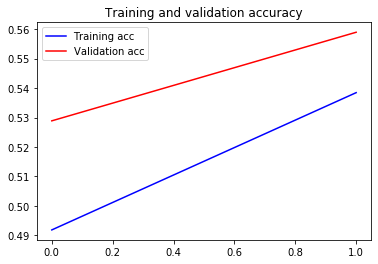

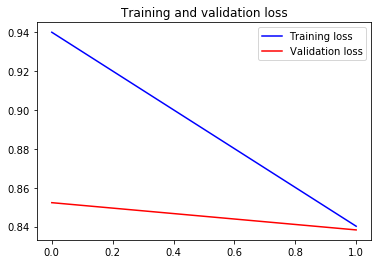

In [113]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Prediction with test set

In [115]:
def label_sentiment(scores):
    maxScore = 0
    maxIdx = 0
    for i in range(len(scores)):
        if scores[i] > maxScore:
            maxScore = scores[i]
            maxIdx = i
    return maxIdx

In [118]:
def predict(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    # Predict
    scores = model.predict([x_test])[0]
    # Decode sentiment
    lblIdx = label_sentiment(scores)
    return labels[lblIdx]  

In [121]:
predict('Im sad!')

'sad'

In [122]:
%%time
y_pred = []
y_test = list(X_test['label'])
scores = model.predict(x_test, verbose=1)
labelscores = [label_sentiment(score) for score in scores]

for lscore in labelscores:
    y_pred.append(labels[lscore])

4155/4155 [==============================] - 28s 7ms/step
Wall time: 28 s


In [123]:
# From Scikit-learn reference
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [127]:
%%time
# print(y_test_1d)
# print(y_pred_1d)
cnf_matrix = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(12,12))
# plot_confusion_matrix(cnf_matrix, classes=labels, title="Confusion matrix")
# plt.show()
plot_confusion_matrix(y_test, y_pred, classes=labels, title='Confusion Matrix')

TypeError: only integer scalar arrays can be converted to a scalar index

In [128]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.25      0.22      0.23      1329
       happy       0.06      0.04      0.05      1375
         sad       0.46      0.62      0.53      1451

    accuracy                           0.30      4155
   macro avg       0.25      0.29      0.27      4155
weighted avg       0.26      0.30      0.27      4155



In [129]:
print(accuracy_score(y_test, y_pred))

0.3003610108303249
